# 05_Model_Degerlendirme

Bu bölümde, eğitilen ve optimize edilen LightGBM modelinin detaylı performans analizi yapılacaktır.

**Amaç:**
1.  **Modelin Karar Mekanizması:** SHAP analizi ile modelin hangi özelliklere (feature) dayanarak karar verdiğini anlamak.
2.  **Hata Analizi:** Confusion Matrix ile modelin nerede hata yaptığını (False Positive vs False Negative) görmek.
3.  **İş Etkisi:** Optimize edilen eşik değerinin (Threshold) metrikler üzerindeki etkisini doğrulamak.

**Kullanılan Artifacts:**
* `models/lgb_model_final.pkl`: Final model.
* `models/best_threshold.txt`: Optimize edilmiş eşik değeri.
* `data/interim/train_features.csv`: Veri seti.

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import joblib
import shap
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve

import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")

DATA_INTERIM = Path("../data/interim")
MODELS = Path("../models")
FIGURES = Path("../figures")

print("Değerlendirme kütüphaneleri hazır.")

Değerlendirme kütüphaneleri hazır.


In [4]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Başlangıç Hafıza: {start_mem:.2f} MB')

    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min, c_max = df[col].min(), df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                df[col] = df[col].astype(np.float32)

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Son Hafıza: {end_mem:.2f} MB')
    return df

# 1. Veri yükleme
print("Veri yükleniyor")
df = pd.read_csv(DATA_INTERIM / "train_features.csv")
df = reduce_mem_usage(df)

# 2. Modeli ve eşik değerini yükleme
model = joblib.load(MODELS / "lgb_model_final.pkl")

with open(MODELS / "best_threshold.txt", "r") as f:
    best_threshold = float(f.read())

print(f"Threshold Değeri: {best_threshold}")

Veri yükleniyor
Başlangıç Hafıza: 443.68 MB
Son Hafıza: 180.91 MB
Threshold Değeri: 0.3999999999999998


In [5]:
# User-based Split 
unique_users = df['user_id'].unique()
np.random.seed(42)

# Kullanıcıların %20'sini Test/Validasyon olarak ayırıyorum
val_users = np.random.choice(unique_users, size=int(len(unique_users) * 0.2), replace=False)
val_mask = df['user_id'].isin(val_users)

# Leakage yapan kolonları çıkar, model training'de çıkardığım kolonlar:
drop_cols = [
    'user_id', 'product_id', 'order_id', 'reordered', 'eval_set', 'add_to_cart_order',
    'up_orders', 'up_last_order_number', 'up_order_rate', 'up_orders_since_last',
    'up_reorder_rate', 'up_cart_mean'
]

X_val = df[val_mask].drop(columns=drop_cols, errors='ignore')
y_val = df[val_mask]['reordered']

print(f"Validasyon seti hazır: {X_val.shape}")

Validasyon seti hazır: (277187, 31)


Tahminler yapılıyor


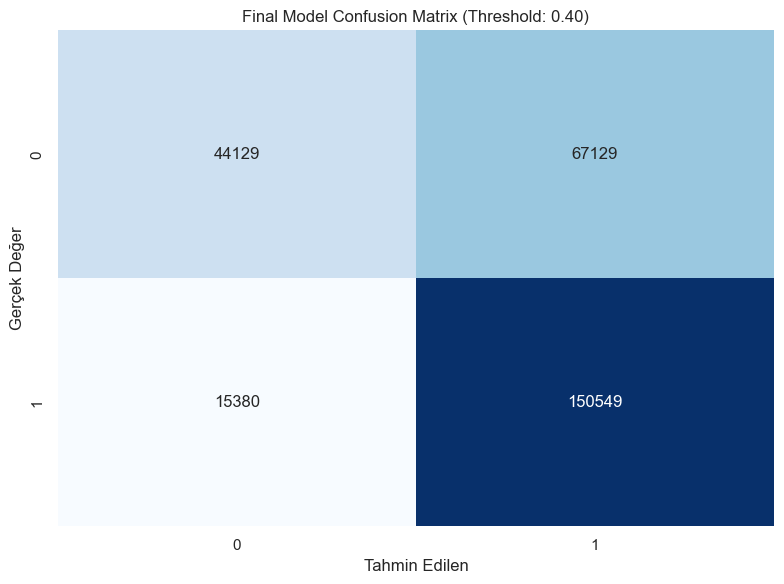


Sınıflandırma Raporu
              precision    recall  f1-score   support

           0       0.74      0.40      0.52    111258
           1       0.69      0.91      0.78    165929

    accuracy                           0.70    277187
   macro avg       0.72      0.65      0.65    277187
weighted avg       0.71      0.70      0.68    277187

ROC-AUC Score: 0.7779


In [7]:
print("Tahminler yapılıyor")
y_prob = model.predict(X_val)
# Optimize edilmiş eşik değerine göre 0/1 dönüşümü
y_pred = (y_prob > best_threshold).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f"Final Model Confusion Matrix (Threshold: {best_threshold:.2f})")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Değer")
plt.tight_layout()
plt.savefig(FIGURES / "confusion_matrix_final.png")
plt.show()

# Detaylı Rapor
print("\nSınıflandırma Raporu")
print(classification_report(y_val, y_pred))

# ROC-AUC
auc_score = roc_auc_score(y_val, y_prob)
print(f"ROC-AUC Score: {auc_score:.4f}")

1.  **Recall:**

    * **Sınıf 1 (Reordered):** **0.91**  Model tekrar alınacak ürünlerin **%91'ini başarıyla yakaladığını** gösteriyor. Modelin başarısı gayet iyi.

2.  **Precision:**

    * **Sınıf 1 (Reordered):** **0.69**  Modelin "Alınır" dediği her 10 üründen yaklaşık 7'sinin gerçekten alındığını gösteriyor. 

3.  **Genel Performans (ROC-AUC):** **0.7779 ROC-AUC**  Model **pozitif ve negatif sınıfları ayırmada %78 oranında** başarılı.

---

>### Baseline (baseline_confusion_matrix.png) vs Final Model Karşılaştırması (confusion_matrix_final.png)

Feature Engineering ve LightGBM optimizasyonu ile elde ettiğim iyileşmeyi, **Confusion Matrix** üzerinde görüyporum.  

* **Baseline (Lojistik Reg):** 141,477 adet doğru tahmin.
* **Final (LightGBM):** 150,549 adet doğru tahmin.
* **Fark:** +9,072 adet daha fazla doğru tahmin. 

---

* **Baseline:** 24,288 ürüne "alınmaz" demiş ama alınmış.
* **Final:** 15,380 ürüne "alınmaz" demiş ama alınmış.
* **Fark:**  -8,908 adet daha fazla doğru tahmin. 

**Sonuç:**
Sadece 1 özellikten (`reorder_ratio`) 31 özelliğe (`user`, `product`, `interaction` vb.) geçiş yapmak ve modeli 0.40 eşik değeriyle optimize etmek, **hem doğruluğu artırmış hem de kaçırılan fırsatları minimize etmiştir.**

SHAP değerleri hesaplanıyor


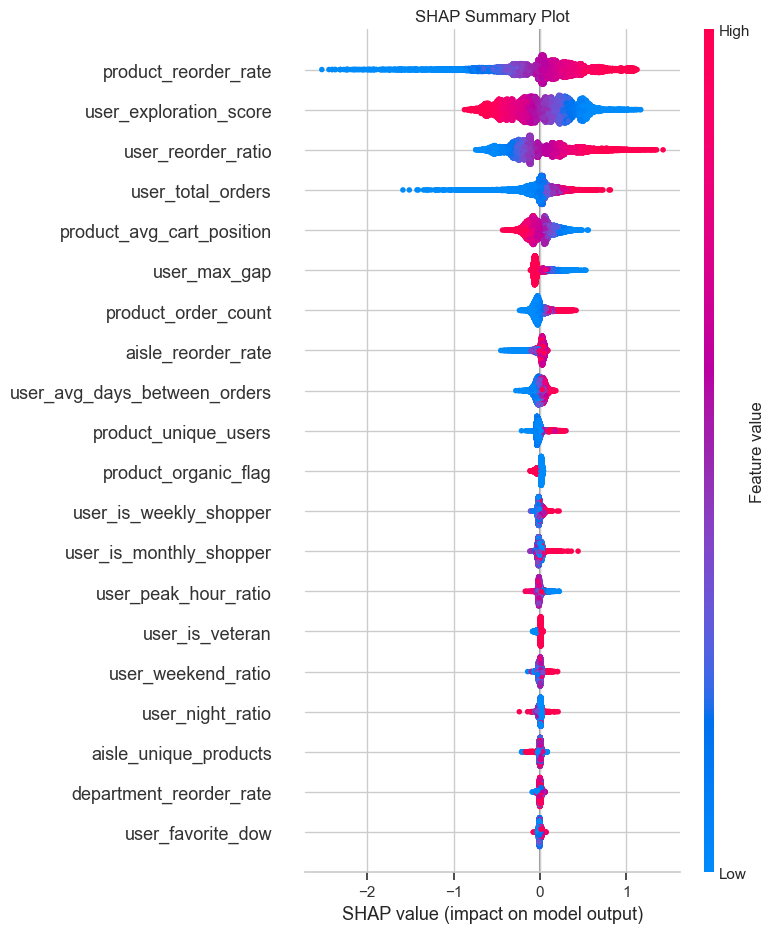

SHAP analizi tamamlandı ve grafik kaydedildi.


In [9]:
print("SHAP değerleri hesaplanıyor")

shap_sample = X_val.sample(n=10000, random_state=42)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(shap_sample)

# Düzeltme: shap_values[1] yerine direkt shap_values kullanıyoruz
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, shap_sample, show=False)
plt.title("SHAP Summary Plot")
plt.tight_layout()

plt.savefig(FIGURES / "shap_summary_plot.png")
plt.show()

print("SHAP analizi tamamlandı ve grafik kaydedildi.")

### SHAP Analizi:

Modelin tahminlerinde hangi özelliklerin belirleyici olduğunu anlamak için SHAP (SHapley Additive exPlanations) değerleri incelenmiştir. Grafik, modelin **mantıksal ve iş zekasına uygun** kararlar verdiğini kanıtlamaktadır.

**Öne Çıkan 3 Kritik Sinyal:**

1.  **`product_reorder_rate` (En Güçlü):**
    * **Analiz:** Grafiğin en güçlü Featuresi Modelin karar vermesini en çok etkileyen özellik. Kırmızı noktalar sağ tarafta pozitif etki gösteriyor.
    * **Yorum:** Süt, Muz gibi  ürünler genel kitle tarafından sıkça tekrar satın alığını analiz etmiştim ve artık model de bu ürünün tekrar alınma ihtimalini çok yüksek görüyor. Bu, modelin **"Ürün Popülaritesine"** güvendiğini gösterir.

2.  **`user_exploration_score` (Negatif Korelasyon):**
    * **Analiz:** Kırmızı noktalar (Yüksek keşif puanı) sol tarafta Negatif etki.
    * **Yorum:** "Kaşif" ruhlu, sürekli yeni ürün deneyen kullanıcıların reorder yapma ihtimali düşüktür. Mavi noktalar (Sadık/Rutin tüketiciler) ise sağda yer alıyor. Bu özellikle model  **Kullanıcı Karakterini** başarıyla öğrenmiş.

3.  **`user_reorder_ratio` (Kullanıcı Alışkanlığı):**
    * **Analiz:** Kırmızı noktalar sağda.
    * **Yorum:** Geçmişinde tekrar satın alma oranı yüksek olan kullanıcılar, gelecekte de bu davranışı sürdürmeye meyillidir. Model, kullanıcının **genel sadakatini** güçlü bir sinyal olarak öğrenmiştir.

**Sonuç:** Sızıntı yapan (Leakage) özelliklerin çıkarılmasıyla 

['user_id', 'product_id', 'order_id', 'reordered', 'eval_set', 'add_to_cart_order','up_orders', 'up_order_rate', 'up_last_order_number', 'up_orders_since_last','up_reorder_rate', 'up_cart_mean'] 

model, birebir ezber yapmak yerine; ürünün genel başarısı ve kullanıcının alışveriş karakteristiği üzerinden **genellenebilir (generalizable)** kararlar vermeyi öğrenmiştir.

### Değerlendirme Sonucu

Model Değerlendirme aşaması, elde edilen **0.7779 F1 skoru** ve SHAP analizi ile doğrulanan **mantıksal karar mekanizması** ile başarıyla tamamladı.

Artık elimde sadece yüksek skorlu bir model değil; **"Neden bu ürünü önerdin?"** sorusuna, *"Çünkü ürün çok popüler ve bu kullanıcı sadık bir müşteri"* gibi iş mantığına (Business Logic) uygun cevaplar verebilen, **sızıntısız (Leakage-free) ve güvenilir** bir sistem bulunmaktadır.

Detaylı açıklamalar ve çıkarımlar **evaluation_report.md** dosyasında dokümante edilmiştir.